<div class="alert alert-block alert-success">

# Programming assignment 2: Random forests, DAT340/DIT867, Applied ML
---
- ## __Alfredo Serafini__
- ## __Erling Hjermstad__
    - ### Group PA2-10
</div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer

In [2]:
train = pd.read_csv("adult_train.csv")
test = pd.read_csv("adult_test.csv")

In [3]:
test

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [4]:
# basic preprocessing stuff
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

x_train = train.drop("target", axis=1)
y_train = train["target"]

x_test = test.drop("target", axis=1)
y_test = test["target"]

x_train_dict = x_train.to_dict('records')
x_test_dict = x_test.to_dict('records')

preprocessing_pipeline = make_pipeline(DictVectorizer(), StandardScaler(with_mean=False)) #disabeling standardscaler makes the output more understandable

x_train = preprocessing_pipeline.fit_transform(x_train_dict)
x_test = preprocessing_pipeline.transform(x_test_dict)

Mean cross-val accuracy: 84.43845110761279 %


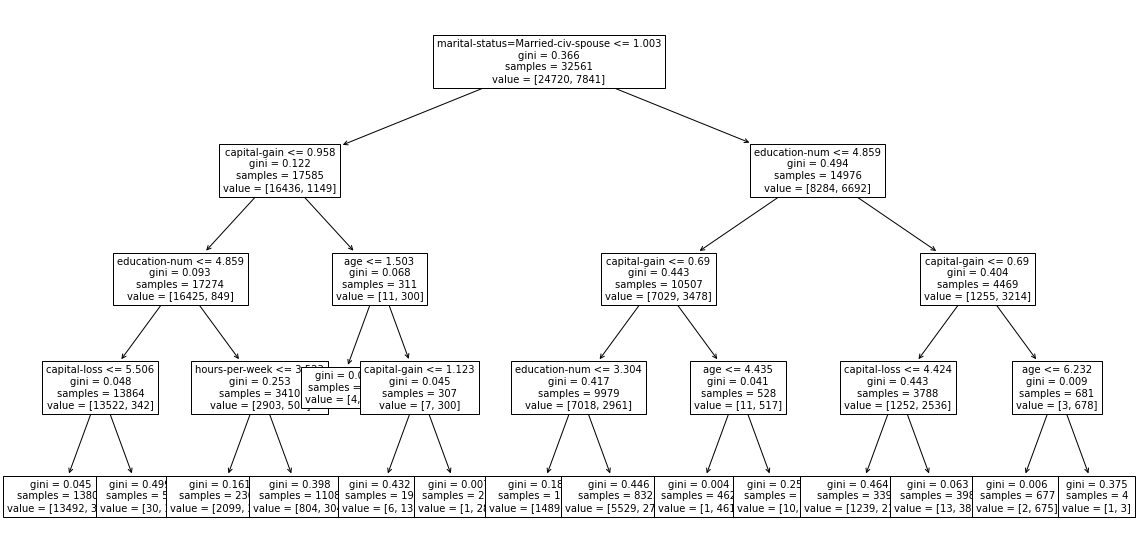

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(max_depth=4)
print("Mean cross-val accuracy:", np.mean(cross_val_score(clf, x_train, y_train))*100, "%")

clf.fit(x_train, y_train)
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=preprocessing_pipeline.get_feature_names_out(), fontsize=10);

#could also include the Decision tree in the pipeline, however we found easier to handle with the classifier outside.
#Had there been a longer pipeline it would have been another deal

In [6]:
# for evaluation
from sklearn.metrics import accuracy_score

# a few different types of classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# turn off annoying warnings
import warnings; warnings.simplefilter('ignore')

# and the VotingClassifier
from sklearn.ensemble import VotingClassifier

In [7]:
ensemble = [
            ('lr', LogisticRegression()),
            ('dt', DecisionTreeClassifier(max_depth=3)),
            ('lr1', LogisticRegression(penalty='l1', solver='liblinear')),
            ('mlp', MLPClassifier(hidden_layer_sizes=(8), max_iter=100))
           ]

In [8]:
voting = VotingClassifier(ensemble)
#voting = VotingClassifier(ensemble, voting='soft', n_jobs=-1, verbose=True) # hard is default
#VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=-1, flatten_transform=True, verbose=False)

voting.fit(x_train, y_train)

accuracy_score(y_test, voting.predict(x_test))

0.8530188563356059

## Task 2 Decision trees and random forest

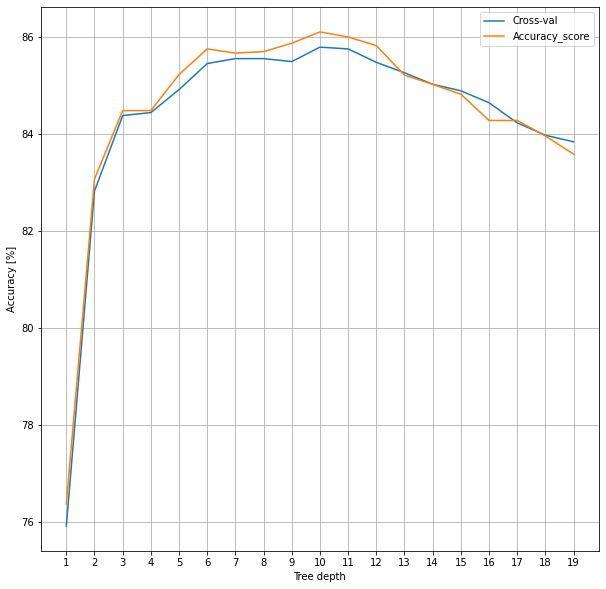

In [52]:
score = []
score2 = []
depth = list(range(1, 20))

for i in depth:
    clf = DecisionTreeClassifier(max_depth=i)
    score.append(100*np.mean(cross_val_score(clf, x_train, y_train, scoring="accuracy")))
    clf.fit(x_train, y_train)
    score2.append(100*accuracy_score(y_test, clf.predict(x_test)))

plt.figure(figsize=(10,10))
plt.xlabel("Tree depth")
plt.ylabel("Accuracy [%]")
plt.xticks(depth)
plt.grid()
plt.plot(depth, score)
plt.plot(depth, score2)
plt.legend(['Cross-val', 'Accuracy_score'])
plt.show()



<div class='alert alert-info'>
The trees are clearly overfitting for depths above 10, and probably a bit before. 2^10=1024 leaf nodes are many nodes, so perhaps a depth of 6 is optimal.
</div>

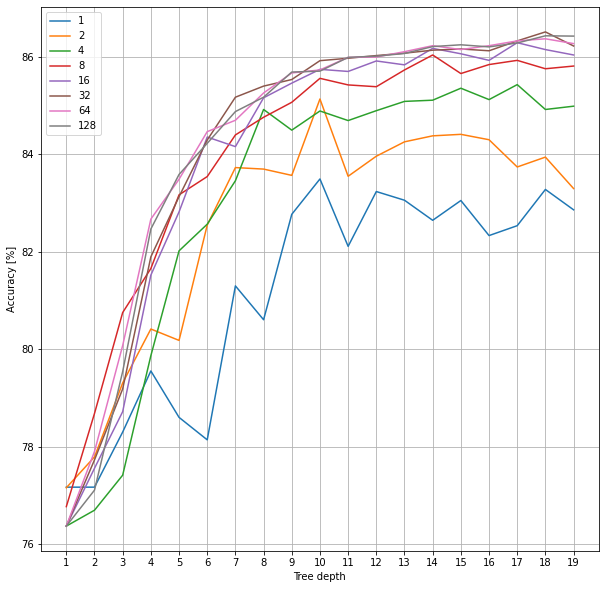

In [10]:
from sklearn.ensemble import RandomForestClassifier

depth = list(range(1, 20))
forest_size = [2**i for i in range(0, 8)]

tot_scores = []

for i in forest_size:
    score = []
    for d in depth:
        rf = RandomForestClassifier(n_estimators=i, max_depth=d, random_state=0, n_jobs=-1)
        rf.fit(x_train, y_train)        
        score.append(100*accuracy_score(y_test, rf.predict(x_test)))
    tot_scores.append(score)

plt.figure(figsize=(10,10))
plt.xlabel("Tree depth")
plt.ylabel("Accuracy [%]")
plt.xticks(depth)
plt.grid()
for ts in tot_scores:
    plt.plot(depth, ts)
plt.legend(forest_size)
plt.show()

<div class='alert alert-info'>
We can see that a huge number of trees in the forest does not improve the accuracy by much compared to around 16. 16 trees does almost as good of a job as 128 trees. With an ensable size of 1 the random disturbances in the training-data are not nulled out by the random disturbances in the other trees, as there is only one tree. Therefore, there are more random fluctuations in the accuracy-curve. The smaller ensambles show signs of overfitting, whilst the bigger ensambles are more resistant to this phenomenon. This is because of the small randomizing of data each tree in the ensambles are trained on making the total ensamble more robust against the variations of real-world data. For increasing depth the bigger ensambles converge towards an accuracy of around 86,5 %, but reach 86% at a depth of 10 making increasing depth unnecessary. Last but not least, with increasing ensemble size, one observe a better accuracy score at the expense of the computation time. 
In conclusion, we found that 16 trees are the right balance between efficiency and final accuracy value.
</div>

## Task 3

In [11]:
# rf.feature_importances_
from sklearn.ensemble import RandomForestClassifier

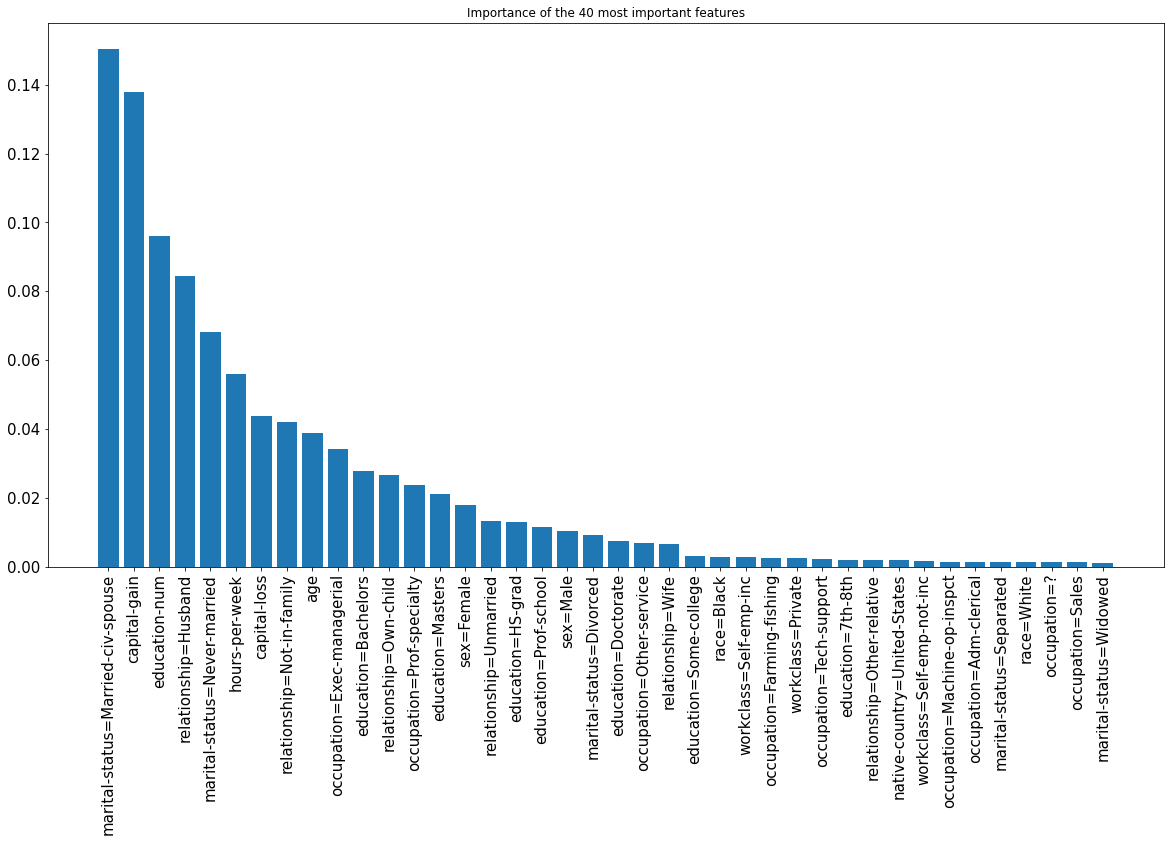

In [24]:
rf = RandomForestClassifier(n_estimators=16, max_depth=10, n_jobs=-1)
rf.fit(x_train, y_train)        

feature_importance = rf.feature_importances_
features = preprocessing_pipeline.get_feature_names_out()


sorting = feature_importance.argsort()[::-1]
feature_importance = feature_importance[sorting]
features = features[sorting]
plt.figure(figsize=(20, 10))
plt.yticks(fontsize=15)
plt.xticks(rotation = 90, fontsize=15)
plt.bar(features[:40], feature_importance[:40])
plt.title("Importance of the 40 most important features")
plt.show()

<div class='alert alert-info'>

We noticed that the feature of being married is rather suspicoius to be a better feature than capital gain to categorize the income of a subject. Marriage is expected to be common in both categories. More valuable feature should be the capital gain, real-estate or stock earnings, and education level. These properties are expected to discriminate between high- and low-income people. 

As exemplified in [Beware Default Random Forest Importances - explained.ai](https://explained.ai/rf-importance/), one possible remedy or alternative to obtain  better feature selections is to employ what is called, _permutation importance_. _Permutation importance_ is highly applicable to any model and is an efficient and reliable technique. What _permutation importance_ technique does is shuffling stochasticly each predictor variable and observe the effect on the model accuracy to estimate the variable importance.
This technique is widely used due to its lack of internal model parameter dependencies, e.g. linear regression coefficients.
</div>

<div class='alert alert-warning'>

### Below are 2 implementations of permutation-importances.

One can see that marital status is no longer the most important feature.
First our implementation:

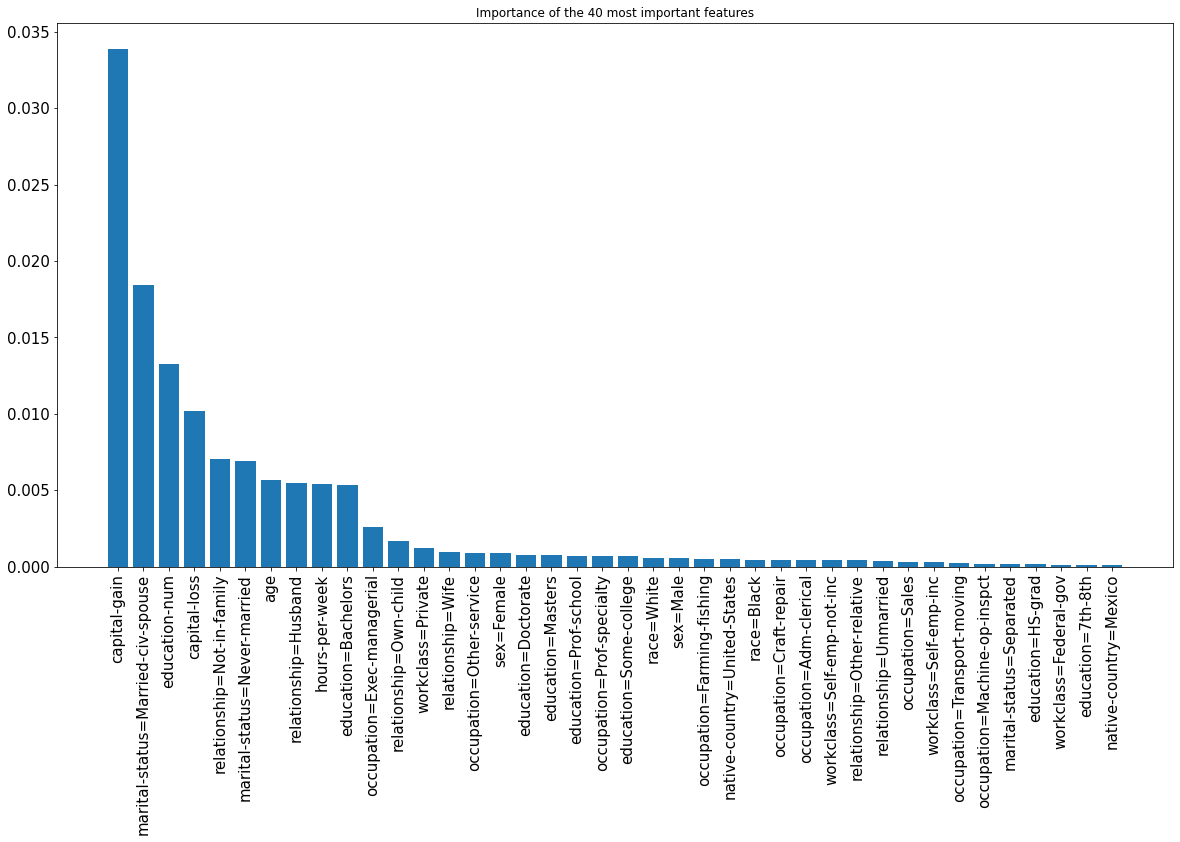

In [40]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf.predict(X_train), y_train)
    imp = []
    for col in range(X_train.shape[1]):        
        save = X_train[:, col].copy()
        X_train[:, col] = X_train[:,col][np.random.permutation(X_train.shape[0])]
        m = metric(rf.predict(X_train), y_train)
        X_train[:, col] = save
        imp.append(baseline - m)
    return np.array(imp)

feature_importance = permutation_importances(rf, x_train, y_train, accuracy_score)
features = preprocessing_pipeline.get_feature_names_out()

sorting = feature_importance.argsort()[::-1]
feature_importance = feature_importance[sorting]
features = features[sorting]
plt.figure(figsize=(20, 10))
plt.yticks(fontsize=15)
plt.xticks(rotation = 90, fontsize=15)
plt.bar(features[:40], feature_importance[:40])
plt.title("Importance of the 40 most important features")
plt.show()

Implemented with Sklearn's function: (slow)

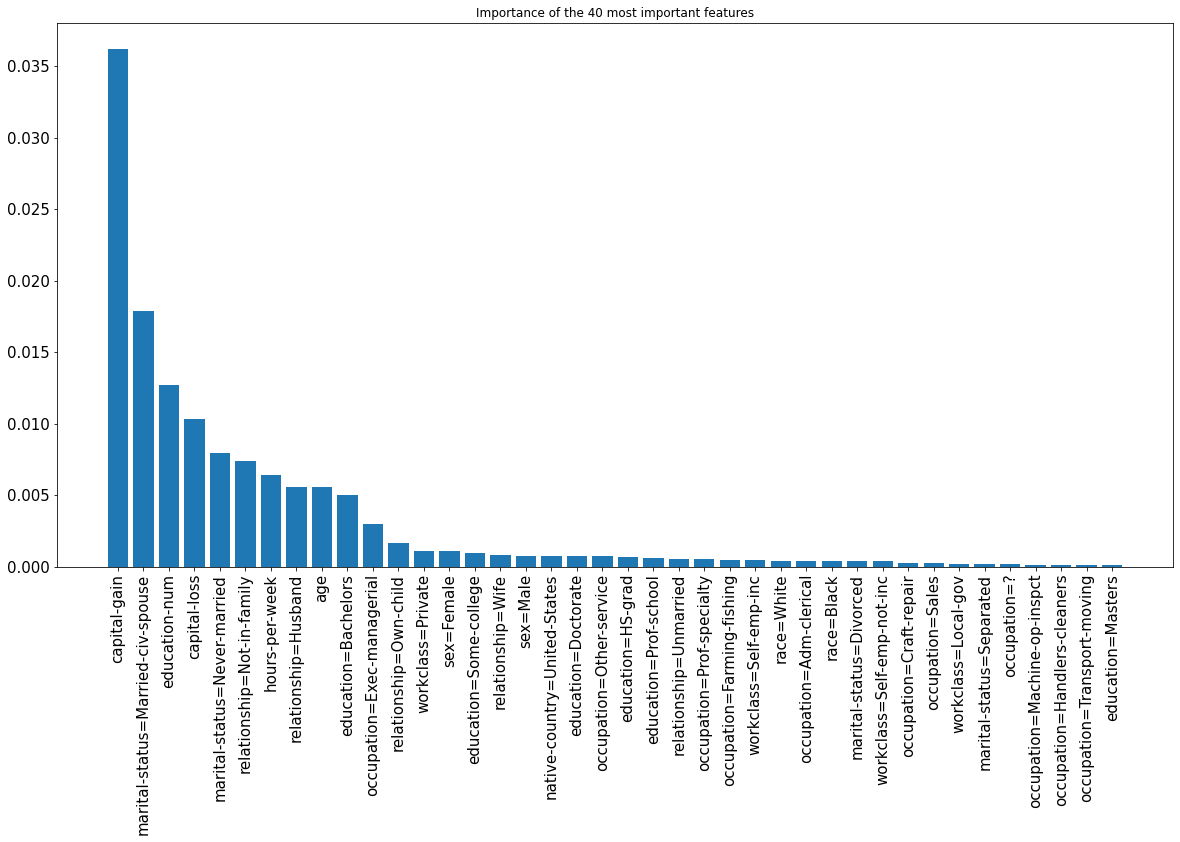

In [41]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf, x_train.toarray(), y_train,
                            n_repeats=15,
                            random_state=0,
                            n_jobs=-1)

sorting = r.importances_mean.argsort()[::-1]
r = r.importances_mean[sorting]
features = preprocessing_pipeline.get_feature_names_out()
features = features[sorting]
plt.figure(figsize=(20, 10))
plt.yticks(fontsize=15)
plt.xticks(rotation = 90, fontsize=15)
plt.bar(features[:40], r[:40])
plt.title("Importance of the 40 most important features")
plt.show()

These two latter plots show that are our results are rather consistent, though using two distinct approaches such as custom function `permutation_importances` and `scikit-learn` library. In other words, we can see that for both scenarios we have _capital-gain_ and _marital-status=Married-civ-spouse, education-num_ and _capital loss_, the most compelling features of per-capita income. 
> Last, in accordance with [Beware Default Random Forest Importances - explained.ai](https://explained.ai/rf-importance/), we found that some features such as the $5^{th}$ and $6^{th}$ one, respectively, are flipped between these two latter plots. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8364d2c7-4800-45ec-a12b-6ea9473a1d6c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>